In [30]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from IPython.display import clear_output

from env import TCLs
from lib.admm import *
from utils.plot import plotDensity, plotStep
import cvxpy as cp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Use Case 1: Reference Tracking

### Create the Generation Following Signal

In [2]:
filePath = "data/"
generation = pd.read_csv(filePath + "CAISO-renewables-20200331.csv")
generation = generation.set_index('Renewables 03/31/2020')
generation = pd.DataFrame(generation.values.T, index = generation.columns, columns= generation.index)

In [3]:
gen = (generation["Solar"] + generation["Wind"]).values

from scipy.interpolate import UnivariateSpline
sp = UnivariateSpline(np.arange(6, len(gen), 12), gen[6::12])
x= np.arange(len(gen))
signal = gen-sp(x)

/Users/chenbq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


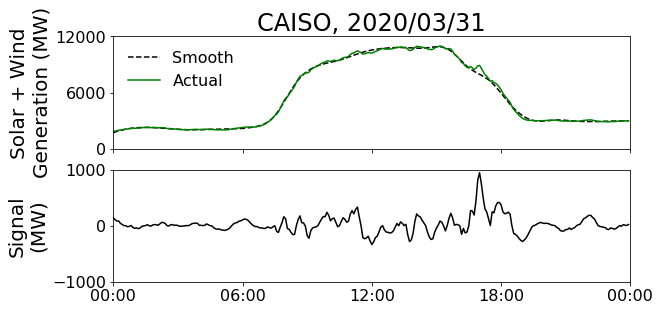

In [4]:
fig, axes = plt.subplots(2, 1, figsize = (8, 4), sharex = 'all')
fig.tight_layout()

start_time = pd.datetime(year = 2020, month = 3, day =31)
end_time = start_time + pd.Timedelta(days = 1)
datelist = pd.date_range(start_time, end_time, freq = '5T').tolist()
datelist = datelist[:288]
t = pd.Series(np.arange(288), index = datelist)

dt = 1/12
x= np.arange(len(gen))

axes[0].plot(t.index.to_pydatetime(), sp(x).reshape(-1), 'k--',  label = "Smooth")
axes[0].plot(t.index.to_pydatetime(), gen, 'g', label = 'Actual')


axes[0].set_title("CAISO, 2020/03/31", fontsize = 24)
axes[0].set_xlim(start_time, end_time)
axes[0].set_yticks([0, 6000, 12000])
axes[0].set_ylabel("Solar + Wind\nGeneration (MW)", fontsize = 20)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].legend(fontsize = 16, frameon = False)

axes[1].plot(t.index.to_pydatetime(), signal, 'k')
axes[1].set_ylabel("Signal\n(MW)", fontsize = 20)
axes[1].tick_params(axis='both', which='major', labelsize=16)

axes[1].set_xticks(t.index.to_pydatetime()[0:-1:72].tolist()+[end_time])
axes[1].set_ylim(-1000, 1000)
myFmt = mdates.DateFormatter('%H:%M')
axes[1].xaxis.set_major_formatter(myFmt)

In [5]:
## Target load profile
n_agent = 1000
signal = gen-sp(x)
signal = signal/1000 # normalize to [-1, 1]

Ta = 32
Tsp = 22.5
Delta = 1
eta = 2.5
R = 2

# Baseline energy consumption from On-Off control
P0 = (Ta-Tsp)/(eta*R) 

P_target = (signal * 5.6 * 0.15 + P0) * n_agent 
P_target = np.clip(P_target, 0, None)

# Padded four hours of random signal so that the population operates in equilibrium
P_target = np.concatenate([np.random.randn(48)*0.02*n_agent+P0*n_agent, P_target])

### Run Experiment

In [6]:
## Define Objective
def g_tracking(v_agg, variable_list):
    return cp.sum_squares(v_agg - variable_list[0])

In [7]:
def Override(u, x, Pm, Tsp = 22.5, Delta = 1):
    u = (u>0)
    #print(u)
    u[x > Tsp+0.9*Delta] = 1
    u[x < Tsp-0.9*Delta] = 0
    #print(u)
    return u * Pm

In [8]:
T = 1 # Planning horizon
dt = 1/12 # Control timestep (Unit: Hour)
step_per_day = int(28/dt)
m = 5 # Ratio between control timestep vs. simulation timestep

rho = 10
eps = 1

env = TCLs.TCL_Cluster(n_agent, Delta =1) 
x_init, u_init, done = env.reset()#x_init = x_rbc[-1], u_init = p_rbc[-1])

print("u_init: ", np.sum(u_init))

param_list = []
Pm_list = []
for agent in env.TCL_list:
    param_list.append(agent.getParameters())
    Pm_list.append(param_list[-1]["Pm"])
Pm = np.array(Pm_list)
    
controllers = ControllerGroup(T, dt, param_list) ## TCL-level Controllers
aggregator = Aggregator(T, g_tracking, [(T)], n_agent, rho) ## Load Aggregator

u_prev = u_init.reshape(n_agent, T) # N x T
controllers.updateState(x_init, u_prev)

x_list = [x_init]
u_list = [] # The continuous solution
p_list = [] # The On-Off actuation
iter_list = [] # Number of iterations

cur_idx = 0
while cur_idx < step_per_day:
    target = P_target[cur_idx:cur_idx+T]

    # Solve the coordination problem
    u_solution, n_iter = ADMM(controllers, aggregator, [target], eps, eps, v_init=np.mean(u_prev, axis =0)) # N x T
    iter_list.append(n_iter)
   
    for u in u_solution.T:
        u_list.append(u)
        tmp = []
        for _ in range(m):
            # Track the agreed upon power profile with PWM
            x, r, p, _ = env.step(u, dt = dt/m, normalized = False, continuous = True)
            tmp.append(p)
            x_list.append(x)
            p_list.append(p)
        print("Target = {}, Actual = {}".format(target, np.mean(tmp)*n_agent))
        
        # We initialized each action with either 0 or 𝑃𝑚 based on its previous action, and switched 
        # if the temperature was close to the edge of the deadband.
        u_prev = Override(p, x, Pm)
        u_prev = u_prev.reshape(n_agent, T)
        
        controllers.updateState(x, u_prev)
        cur_idx+=1
        print("T = {}, Num. Of Iter. = {}".format(cur_idx, n_iter))

u_init:  2102.81727782613
Target = [1908.17331806], Actual = 1952.2834805768741
T = 1, Num. Of Iter. = 6
Target = [1900.72793399], Actual = 1945.5839700766599
T = 2, Num. Of Iter. = 6
Target = [1933.63156113], Actual = 1646.4073708775395
T = 3, Num. Of Iter. = 6
Target = [1892.83355959], Actual = 1967.388723217959
T = 4, Num. Of Iter. = 6
Target = [1867.82969022], Actual = 1720.8659617369551
T = 5, Num. Of Iter. = 5
Target = [1900.55567726], Actual = 1892.372886059403
T = 6, Num. Of Iter. = 5
Target = [1912.71097389], Actual = 1964.5957202559584
T = 7, Num. Of Iter. = 5
Target = [1915.44679473], Actual = 1989.339487612644
T = 8, Num. Of Iter. = 6
Target = [1906.58368151], Actual = 1973.2967637495792
T = 9, Num. Of Iter. = 6
Target = [1905.0526017], Actual = 2028.3691380025869
T = 10, Num. Of Iter. = 6
Target = [1921.33445825], Actual = 1959.8670394626824
T = 11, Num. Of Iter. = 6
Target = [1865.02519156], Actual = 1860.5605195792136
T = 12, Num. Of Iter. = 6
Target = [1884.20480894], A

Target = [1895.76664736], Actual = 1935.3336875289208
T = 104, Num. Of Iter. = 6
Target = [1869.25085404], Actual = 1891.6307140066772
T = 105, Num. Of Iter. = 6
Target = [1852.39099719], Actual = 1865.0053544337668
T = 106, Num. Of Iter. = 6
Target = [1846.74239014], Actual = 1872.0830251386512
T = 107, Num. Of Iter. = 6
Target = [1850.50034621], Actual = 1858.1990903232631
T = 108, Num. Of Iter. = 6
Target = [1838.34017873], Actual = 1853.1260204345388
T = 109, Num. Of Iter. = 7
Target = [1833.65720102], Actual = 1887.2345034072898
T = 110, Num. Of Iter. = 6
Target = [1828.76672641], Actual = 1866.215762808361
T = 111, Num. Of Iter. = 6
Target = [1836.14406823], Actual = 1804.2955347887964
T = 112, Num. Of Iter. = 6
Target = [1846.42453979], Actual = 1822.7874964604575
T = 113, Num. Of Iter. = 6
Target = [1867.88345444], Actual = 1836.3987055351479
T = 114, Num. Of Iter. = 6
Target = [1899.55612548], Actual = 1868.9639127968737
T = 115, Num. Of Iter. = 6
Target = [1926.1909483], Actu

T = 205, Num. Of Iter. = 6
Target = [1877.38643407], Actual = 1971.7614888567932
T = 206, Num. Of Iter. = 6
Target = [1932.5535247], Actual = 1880.7508951755317
T = 207, Num. Of Iter. = 6
Target = [1899.0120958], Actual = 1852.4258331119136
T = 208, Num. Of Iter. = 6
Target = [1956.56102821], Actual = 1954.5026284834587
T = 209, Num. Of Iter. = 6
Target = [1934.71920277], Actual = 2075.554828280642
T = 210, Num. Of Iter. = 6
Target = [1900.7255003], Actual = 1799.5970679800864
T = 211, Num. Of Iter. = 6
Target = [1920.02252123], Actual = 1870.7236030821186
T = 212, Num. Of Iter. = 5
Target = [1764.42774431], Actual = 1726.1493337320892
T = 213, Num. Of Iter. = 7
Target = [1661.76236787], Actual = 1693.7877207238446
T = 214, Num. Of Iter. = 7
Target = [1686.96759025], Actual = 1711.417179431678
T = 215, Num. Of Iter. = 6
Target = [1787.30460979], Actual = 1798.924672809527
T = 216, Num. Of Iter. = 6
Target = [1967.15462481], Actual = 1935.750466751949
T = 217, Num. Of Iter. = 6
Target =

T = 307, Num. Of Iter. = 5
Target = [1913.75471103], Actual = 1948.0665540472028
T = 308, Num. Of Iter. = 5
Target = [1921.80817945], Actual = 1929.5618191556673
T = 309, Num. Of Iter. = 5
Target = [1962.65550973], Actual = 1949.4452980622518
T = 310, Num. Of Iter. = 5
Target = [2003.64906262], Actual = 1971.5629437307603
T = 311, Num. Of Iter. = 5
Target = [2016.34119884], Actual = 2076.1824635654075
T = 312, Num. Of Iter. = 5
Target = [2040.32427912], Actual = 1990.2458036787125
T = 313, Num. Of Iter. = 5
Target = [2054.71066418], Actual = 2087.3045879552124
T = 314, Num. Of Iter. = 5
Target = [2052.89271477], Actual = 2101.636467508693
T = 315, Num. Of Iter. = 6
Target = [2021.5427916], Actual = 1983.8529449691982
T = 316, Num. Of Iter. = 5
Target = [1998.57325541], Actual = 1975.749517546885
T = 317, Num. Of Iter. = 5
Target = [1947.97646692], Actual = 1976.9931912377044
T = 318, Num. Of Iter. = 5
Target = [1900.10478687], Actual = 1889.2358610020412
T = 319, Num. Of Iter. = 5
Targ

### Save Results

In [13]:
result_dict = {"param_list":param_list, 
               "x_init":x_init, 
               "u_init":u_init, 
               "x_list":x_list[-int(1+24/dt*m):], 
               "u_list":u_list[-int(24/dt):],
               "p_list":p_list[-int((24/dt*m)):],
               "m":m,
               "iter_list": iter_list}
import pickle
with open('results/tracking_result', 'wb') as file:
    pickle.dump(result_dict, file)

### Plot Results

In [42]:
tracking_dict = pickle.load(open('results/tracking_result', 'rb'))
P_list = np.array(tracking_dict['p_list'])
m = np.array(tracking_dict['m'])
tmp = np.sum(P_list, axis =1)
P_avg = []
for i in range(len(tmp)//m):
    P_avg.append(np.mean(tmp[m*i : m*(i+1)]))
tracking_dict['p_avg'] = P_avg

In [43]:
start_time = pd.datetime(year = 2020, month = 3, day =31)
end_time = start_time + pd.Timedelta(days = 1)
datelist = pd.date_range(start_time, end_time, freq = '5T').tolist()
datelist = datelist
t_5min = pd.Series(np.arange(289), index = datelist).index.to_pydatetime()
t_5min = t_5min[:-1]

/Users/chenbq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


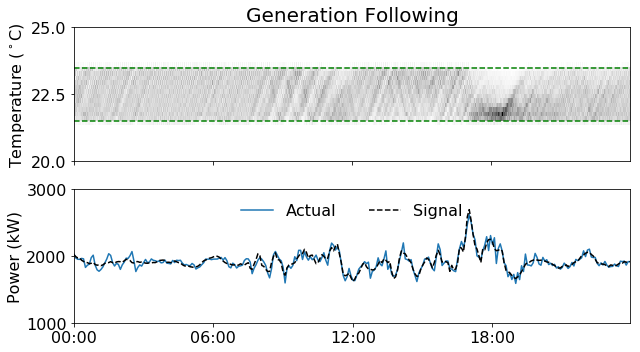

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(9,5))

myFmt = mdates.DateFormatter('%H:%M')

bins = np.arange(Tsp-1.5*Delta, Tsp+1.5*Delta+1e-3, Delta/6) 
deadband = [Tsp-Delta, Tsp+Delta]
## Use Case 1
plotDensity(tracking_dict['x_list'], axes[0], bins, deadband)
axes[0].set_title("Generation Following", fontsize = 20)
axes[0].set_ylabel("Temperature ($^\circ$C)", fontsize = 16)
axes[0].tick_params(axis='x', which='both', labelbottom=False)
axes[0].tick_params(axis='y', which='major', labelsize=16)
axes[0].set_yticks([20, 22.5, 25])
axes[0].set_xticks([0, 6, 12, 18])

axes[1].plot(t_5min, np.array(tracking_dict['p_avg']), label = "Actual")
axes[1].plot(t_5min, P_target[-288:], 'k--', label = 'Signal')
axes[1].set_ylabel("Power (kW)", fontsize = 16)
axes[1].set_ylim(1000, 3000)
axes[1].set_yticks([1000, 2000, 3000])

axes[1].set_xlim(start_time, t_5min[-1])
axes[1].set_xticks(t_5min[::6*12].tolist())
axes[1].xaxis.set_major_formatter(myFmt)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].legend(fontsize = 16, loc = 'upper center', frameon = False, ncol = 2)

fig.tight_layout()